In [272]:
## numerical and models processing
import torch
import numpy as np
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

import matplotlib.pyplot as plt

import nltk

import sys
sys.path.append('/kaggle/input/utils-trab-compcientifica/')
import utils

# Preliminary Experimentation

In [273]:
spam_df = pd.read_pickle('/kaggle/input/utils-trab-compcientifica/spam_df.pkl')

In [274]:
indexes = []
for i in spam_df.index:
    if len(spam_df['transformed_text'][i]) < 1:
        continue
    indexes.append(i)
spam_df = spam_df.loc[indexes]

In [275]:
vocab = []
for text in spam_df['transformed_text']:
    vocab.extend(text.split())
vocab = sorted(list(set(vocab)))
vocab_dict = {}
for e, i in enumerate(vocab):
    vocab_dict[i] = e+1
vocab_dict[0] = 0

In [276]:
def prepare_sequence(seq, to_ix, n_words):
    idxs = [to_ix[w] for w in seq]
    if len(idxs) < n_words:
       idxs.extend([0]*(n_words-len(idxs)))
    return torch.tensor(idxs, dtype=torch.long)

In [327]:
class Simple_RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim,vocab_size, num_layers=1):
        super(Simple_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.words_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.out_layer = nn.Linear(hidden_dim, 1)
    def forward(self, batch):
        seq_lens = [len(c[c!=0]) for c in batch]
        embeds = self.words_embeddings(batch)
        packed = pack_padded_sequence(embeds, seq_lens, batch_first=True, enforce_sorted=False)
        rnn_outs, _= self.rnn(packed)
        seqs, lens = pad_packed_sequence(rnn_outs, batch_first=True)
        y_pred = []
        for e, _ in enumerate(seqs):
            y_pred.append(seqs[e][lens[e]-1])
        y_pred = torch.vstack(y_pred)
        out = self.out_layer(y_pred)
        return out

In [326]:
model = Simple_RNN(32, 4, len(vocab_dict)).to('cuda')
sentence = prepare_sequence(spam_df['transformed_text'].iloc[0].split(), vocab_dict, 100).to('cuda').unsqueeze(0)
model(sentence)

[16]


tensor([[0.1901]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [181]:
class Simple_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim,vocab_size, num_layers=1):
        super(Simple_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.words_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.out_layer = nn.Linear(hidden_dim, 1)
    def forward(self, sentence):
        embeds = self.words_embeddings(sentence)
        _, lstm_out = self.lstm(embeds)
        out = self.out_layer(lstm_out[0])
        return out

In [50]:
model = Simple_LSTM(32, 4, len(vocab_dict))
sentence = prepare_sequence(spam_df['transformed_text'][0].split(), vocab_dict, 250)
model(sentence)

tensor([[-0.3592]], grad_fn=<AddmmBackward0>)

# Pytorch Dataset

In [113]:
spam_df = pd.concat([spam_df.loc[spam_df[spam_df['target'] == 0].sample(n=641, random_state = 42).index], spam_df[spam_df['target']==1]])

In [114]:
spam_df

,Category,text,target,num_characters,num_words,num_sentence,transformed_text
926,ham,"K, wait chikku..il send aftr &lt;#&gt; mins",0,44,16,1,k wait chikku il send aftr lt gt min
1555,ham,Yeah we do totes. When u wanna?,0,31,10,2,yeah tote u wan na
4322,ham,"K, jason says he's gonna be around so I'll be ...",0,72,24,1,k jason say gon na around around lt gt
1147,ham,Babe ? I lost you ... :-(,0,25,9,2,babe lost
3896,ham,Yes. Last practice,0,19,4,2,ye last practic
...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,1,90,18,3,want explicit sex 30 sec ring 02073162414 cost...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1,158,38,6,ask 3mobil 0870 chatlin inclu free min india c...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,1,160,35,5,contract mobil 11 mnth latest motorola nokia e...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1,147,30,1,remind o2 get pound free call credit detail gr...


In [328]:
class SPAM_Detection_Dataset():
    def __init__(self, spam_df, vocab_dict, max_n_words=250):
        self.sentences = spam_df['transformed_text'].apply(lambda x: prepare_sequence(x.split(), to_ix=vocab_dict, n_words=max_n_words)).tolist()
        self.labels = spam_df['target'].apply(torch.tensor).tolist()

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

In [329]:
from sklearn.model_selection import train_test_split

X = spam_df.index.tolist()
Y = spam_df['target'].tolist()
train_val_idx, test_idx, train_val_labels, _ = train_test_split(X, Y, stratify=Y, test_size=0.25)
train_idx, val_idx, _, _ = train_test_split(train_val_idx, train_val_labels, stratify=train_val_labels, test_size=0.25)
train_df = spam_df.loc[train_idx]
val_df = spam_df.loc[val_idx]
test_df = spam_df.loc[test_idx]

In [330]:
trainset = SPAM_Detection_Dataset(train_df, vocab_dict)
valset = SPAM_Detection_Dataset(val_df, vocab_dict)
testset = SPAM_Detection_Dataset(test_df, vocab_dict)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=64, num_workers=4)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=64, num_workers=4)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=64, num_workers=4)

# Training

In [332]:
dev = 'cuda'
model = Simple_RNN(embedding_dim=32, hidden_dim=4, vocab_size=len(vocab_dict), num_layers=4)
model.to(dev)
criterion = nn.BCELoss()

sigmoid = nn.Sigmoid()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for epoch in range(10):
    print(epoch)
    running_loss = 0
    model.eval()
    with torch.no_grad():
        for sentence, label in valloader:
            sentence = sentence.to(dev)
            label = label.to(dev).unsqueeze(1).float()
            output = model(sentence).squeeze(0)
            loss = criterion(sigmoid(output), label)
            running_loss += loss
        val_loss.append((running_loss/len(valset)).item())
        
    running_loss = 0
    model.train()
    for sentence, label in trainloader:
        model.zero_grad()
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        loss = criterion(sigmoid(output), label)
        loss.backward()
        optimizer.step()
        running_loss += loss
    train_loss.append((running_loss/len(trainset)).item())

0
1
2
3
4
5
6
7
8
9


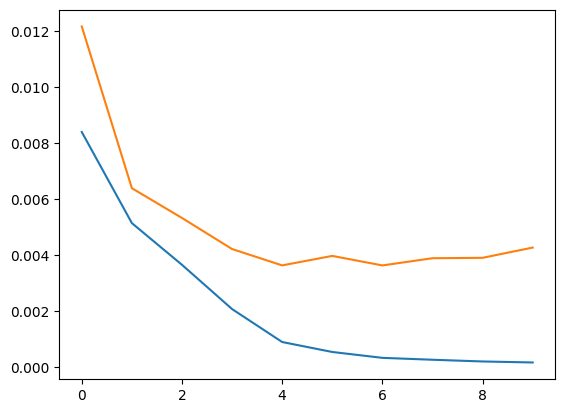

In [333]:
plt.plot(train_loss)
plt.plot(val_loss)

In [336]:
running_loss = 0
th = 0.5
with torch.no_grad():
    outputs = []
    labels = []
    for sentence, label in testloader:
        sentence = sentence.to(dev)
        label = label.to(dev).unsqueeze(1).float()
        output = model(sentence).squeeze(0)
        loss = criterion(sigmoid(output), label)
        outputs.extend((sigmoid(output) > th).float())
        labels.extend(label)
        running_loss += loss
    test_loss = running_loss/len(testset)
    print(test_loss)

tensor(0.0043, device='cuda:0')


In [337]:
sum([otp == lbl for otp, lbl in zip(outputs, labels)])/len(labels)

tensor([0.9394], device='cuda:0')